In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import pickle
from copy import deepcopy

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from itertools import permutations, combinations

from datasets import Data_From_File
from sklearn.metrics import ndcg_score
from perms import Gk

import matplotlib.pyplot as plt

In [2]:
class Data_for_torch(Dataset, Data_From_File):
    
    def __init__(self, file, which = 0):
        
        self.data = pd.DataFrame(Data_From_File.open_file(file)[which]).drop('doc_id', axis = 1)
        self.dict_data = self.data.set_index('query_id').T.to_dict('list')
        self.keys = list(self.dict_data.keys())
        
    def __len__(self):
        return len(self.dict_data)
        
    def __getitem__(self, idx):
        key = self.keys[idx]
        return self.dict_data[key]

In [3]:
train_data = Data_for_torch('datas_full_10k_1.pkl', which = 0)
vali_data = Data_for_torch('datas_full_10k_1.pkl', which = -1)

In [4]:
train_loader = DataLoader(train_data, shuffle=True)
test_loader = DataLoader(vali_data, batch_size=1)

In [5]:
class ListNet(nn.Module):
    def __init__(self,inp_size = 136, out_size = 1):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(inp_size, 256),
            nn.ReLU(),
            nn.Linear(256,128),
            nn.ReLU(),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Linear(64,out_size),
            
            
        )
        
    def forward(self, X):
        return self.model(X)
    
    dict_y = {}

In [20]:
def get_ndcg():
    pass
def loss(p,y):
    return torch.sum(y * torch.log(y / (p + 1e-6)))

def train(train_dataloader, model, loss_fn, optimizer,sheluder, epochs, device, test = False, test_dataloader = None, k = 1):
    global dict_y
    
    # model.to(device)
    
    pred_probs = nn.Softmax()
    y_probs = nn.Softmax()
    
    train_loss = []
    
    model.train()
    for i in range(epochs):
        
        loss_epoch = 0
        
        
        for batch in train_dataloader:
            X = batch[0].float().to(device)
            y = batch[1].squeeze().float().to(device)
            
            preds = model(X).squeeze()
            
            probas_p = pred_probs(preds)
            probas_y = y_probs(y)
            
            loss_ = loss_fn(probas_p, probas_y)
            # los_ = kl_loss(probas_p, probas_y)
            # print(loss_)
            loss_.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            loss_epoch += loss_
            
        sheluder.step(loss_epoch)  
        
        train_loss.append(loss_epoch.clone().detach().cpu().numpy()/6000)
        print(loss_epoch/6000)
        
        # for name, param in model.named_parameters():
        #     if param.grad is not None:
        #         print(f'Градиент параметра {name}: {param.grad}')
        #     else:
        #         print(f'Градиент параметра {name} отсутствует')          
            
    return train_loss
    
    
        
from sklearn.metrics import ndcg_score

def vali(loader, device = 'cuda'):
    acc = 0
    
    length = len(loader)
    for batch in loader:
        # get_probs = torch.softma
        
        
        X = batch[0].to(device)
        y = batch[1].cpu().view(-1).numpy()
        
        preds = model(X.float()).view(-1).detach().cpu().numpy()
        # print(y.shape, preds.shape, X.shape)
        try:
            acc += ndcg_score([list(y)], [list(preds)])
        except:
            # acc += 1
            length -= 1
            continue
        
    return acc / length
    # return ndcg_score(list_of_y, list_of_preds)
        
def plot_loss(train_loss, num_epochs = 50):
        plt.figure(figsize = (10,10))
        
        fig, ax = plt.subplots()
        ax.set_title('train_loss')
        ax.plot(range(num_epochs),train_loss)
        ax.set_xlabel('epochs')
        ax.set_ylabel('loss')
        plt.grid()
        plt.show()
        
            

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = ListNet().to(device)

kl_loss = nn.CrossEntropyLoss()

opt_adam = torch.optim.AdamW(model.parameters(), lr=0.0001)

m_loss = nn.MSELoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt_adam, mode='min', patience=3, factor=0.1, verbose=True)

/home/aletovv/anaconda3/envs/v-env/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [13]:
model_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Number of trainable parameters: {model_total_params}')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

Number of trainable parameters: 76289


'cuda'

In [14]:
losses = train(train_dataloader=train_loader,
      model = model,
      loss_fn=loss,
      optimizer=opt_adam,sheluder=scheduler,
      epochs=50,
      device = device)

/home/aletovv/anaconda3/envs/v-env/lib/python3.12/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


tensor(9.0204, device='cuda:0', grad_fn=<DivBackward0>)
tensor(5.7753, device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.1860, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.8389, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.5893, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.4525, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.4416, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.4402, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.4364, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.4357, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.4405, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.4322, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.4300, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.4335, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.4231, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.4257, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.4444, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.4216, device='cuda:0', grad_fn=<DivBack

<Figure size 1000x1000 with 0 Axes>

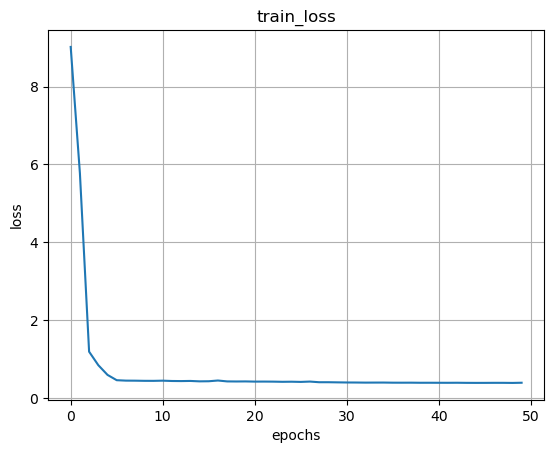

In [21]:
plot_loss(train_loss=losses)

In [22]:
print(f'the ndcg_score for trained model = {vali(test_loader )}')

the ndcg_score for trained model = 0.7232866724326324
